In [39]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from copy import deepcopy
import sys


#参数设置
NUM_CUSTOMERS = 20 #客户数量
DEPOT_COORD = (50, 50) #仓库坐标
MAX_COORD = 100 #坐标最大值
VEHICLE_SPEED = 1.0 # 车辆速度
PENALTY_LATE_COEFFICIENT = 5.0 # 惩罚系数（每迟到一个时间单位罚款）

# Tabu Search
TS_TABU_TENURE_CUSTOMER = 5 # 移动客户的禁忌期
TS_TABU_TENURE_2OPT = 7    # 2-opt禁忌期
TS_MAX_ITERATIONS = 750 #最大迭代次数
TS_ASPIRATION_OFFSET = 0.01 # 渴望准则偏移量，允许接受比历史最优稍差一点的禁忌移动


nodes coords:
[(50, 50), (81, 14), (3, 94), (35, 31), (28, 17), (94, 13), (86, 94), (69, 11), (75, 54), (4, 3), (11, 27), (29, 64), (77, 3), (71, 25), (91, 83), (89, 69), (53, 28), (57, 75), (35, 0), (97, 20), (89, 54)]
time windows:
[[0, 1000], [174, 259], [79, 156], [390, 483], [52, 113], [194, 256], [183, 277], [309, 392], [22, 165], [235, 353], [63, 161], [40, 160], [150, 280], [316, 412], [295, 369], [360, 418], [23, 157], [116, 264], [148, 208], [119, 181], [194, 279]]


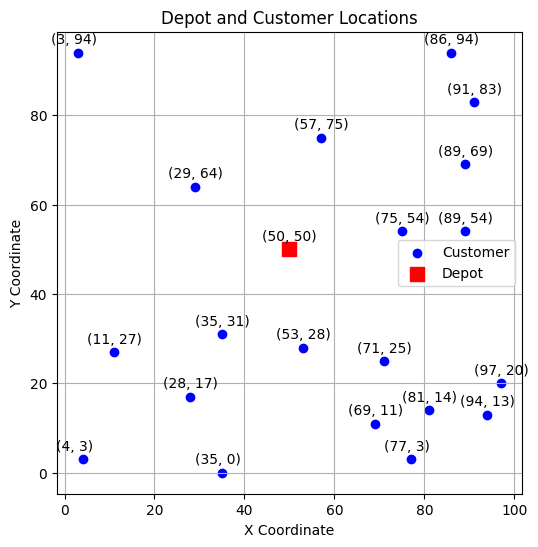

In [40]:
# --- Data Generation ---
np.random.seed(42)
random.seed(42) #种子

customer_coords = [(random.randint(0, MAX_COORD), random.randint(0, MAX_COORD))
                   for _ in range(NUM_CUSTOMERS)] #生成客户坐标

# 时间窗设置
depot_time_window = [0, 1000]
time_windows_customers = []
for i in range(NUM_CUSTOMERS):
    earliest = random.randint(0, 400)
    latest = earliest + random.randint(50, 150)
    time_windows_customers.append([earliest, latest])

# Combined data
nodes_coords = [DEPOT_COORD] + customer_coords #加上仓库坐标
NUM_NODES = len(nodes_coords)
time_windows = [depot_time_window] + time_windows_customers
print('nodes coords:')
print(nodes_coords)

print('time windows:')
print(time_windows)

# 初始点可视化
plt.figure(figsize=(6,6))
x_coords, y_coords = zip(*nodes_coords)
plt.scatter(x_coords, y_coords, c='blue', label='Customer')
plt.scatter(DEPOT_COORD[0], DEPOT_COORD[1], c='red', marker='s', s=100, label='Depot')
for i, (x, y) in enumerate(nodes_coords):
   plt.text(x-6, y+2, str(nodes_coords[i]))
plt.title('Depot and Customer Locations')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
def calculate_distance_matrix(nodes):
    """距离矩阵计算"""
    nodes_array = np.array(nodes)
    dx = nodes_array[:, 0, None] - nodes_array[:, 0]  # X坐标
    dy = nodes_array[:, 1, None] - nodes_array[:, 1]  # Y坐标
    matrix = np.sqrt(dx**2 + dy**2)
    return np.round(matrix, 2)   # 保留两位小数

# 生成并打印距离矩阵
DISTANCE_MATRIX = calculate_distance_matrix(nodes_coords)
print("Distance Matrix (first 10 raws):")
print(DISTANCE_MATRIX[:10,:10])

# ================== 路径成本计算优化 ==================
def calculate_single_route_cost(route, distance_matrix, time_windows,
                                penalty_late_coeff, speed=1.0):
    """单路径成本计算"""
    if len(route) < 2: # 处理空路径或无效路径
        return 0.0, 0.0, 0.0, {}

    total_distance = 0.0
    total_late_penalty = 0.0
    current_time = 0.0
    arrival_times = {route[0]: 0.0}  # 起点时间初始化


    for i in range(len(route)-1):
        u, v = route[i], route[i+1]

        # 计算行驶数据
        distance = distance_matrix[u][v]
        travel_time = distance / speed

        # 时间计算
        arrival_u = current_time
        departure_u = max(arrival_u, time_windows[u][0])  # 仅考虑等待时间

        arrival_v = departure_u + travel_time
        arrival_times[v] = arrival_v

        # 计算惩罚（仓库特殊处理）
        if v != 0:  # 客户节点
            latest = time_windows[v][1]
            penalty = max(arrival_v - latest, 0) * penalty_late_coeff
            total_late_penalty += penalty
            current_time = arrival_v  # 客户节点更新时间
        else:       # 返回仓库
            penalty = max(arrival_v - time_windows[0][1], 0) * penalty_late_coeff
            total_late_penalty += penalty

        total_distance += distance

    total_cost = total_distance + total_late_penalty
    return total_cost, total_distance, total_late_penalty, arrival_times

def calculate_solution_cost(solution, distance_matrix, time_windows,
                            penalty_late_coeff, speed=1.0):
    """整体方案成本计算(单路经累加)"""
    total_cost, total_distance, total_penalty = 0.0, 0.0, 0.0
    all_arrival_times = []

    for route in solution:
        if len(route) > 1:  # 有效路径判断
            cost, dist, penalty, arrivals = calculate_single_route_cost(
                route, distance_matrix, time_windows,
                penalty_late_coeff, speed
            )
            total_cost += cost
            total_distance += dist
            total_penalty += penalty
            all_arrival_times.append(arrivals)
        else:
            all_arrival_times.append({})

    return total_cost, total_distance, total_penalty, all_arrival_times

Distance Matrix (first 10 raws):
[[  0.    47.51  64.38  24.21  39.66  57.49  56.85  43.38  25.32  65.76]
 [ 47.51   0.   111.73  49.04  53.08  13.04  80.16  12.37  40.45  77.78]
 [ 64.38 111.73   0.    70.66  80.96 121.83  83.   106.04  82.37  91.01]
 [ 24.21  49.04  70.66   0.    15.65  61.68  81.06  39.45  46.14  41.77]
 [ 39.66  53.08  80.96  15.65   0.    66.12  96.4   41.44  59.82  27.78]
 [ 57.49  13.04 121.83  61.68  66.12   0.    81.39  25.08  45.19  90.55]
 [ 56.85  80.16  83.    81.06  96.4   81.39   0.    84.72  41.48 122.49]
 [ 43.38  12.37 106.04  39.45  41.44  25.08  84.72   0.    43.42  65.49]
 [ 25.32  40.45  82.37  46.14  59.82  45.19  41.48  43.42   0.    87.42]
 [ 65.76  77.78  91.01  41.77  27.78  90.55 122.49  65.49  87.42   0.  ]]


route1: [0, 16, 3, 13, 7, 0]
route2: [0, 11, 17, 8, 20, 15, 14, 0]
route3: [0, 4, 18, 9, 12, 0]
route4: [0, 10, 2, 6, 1, 0]
route5: [0, 19, 5, 0]
total cost: 1628.50


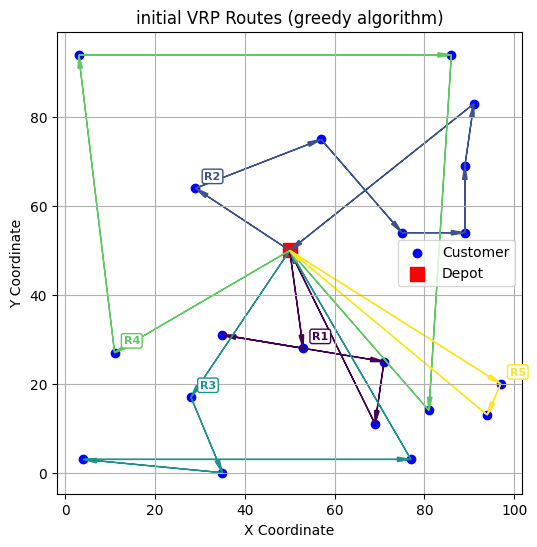

In [42]:
# --- Initial Solution Generation ---


def initial_solution_greedy(distance_matrix, time_windows, penalty_coeff, speed=1.0, depot_tol=50):
    customers = list(range(1, len(distance_matrix)))
    solution = []
    unassigned = set(customers)

    while unassigned:
        # 新建路径并选择起始客户
        route = [0]
        current_time = 0.0

        # 寻找离仓库最近的可行客户
        first_cust = min(unassigned,
                        key=lambda c: distance_matrix[0][c],
                        default=-1)
        if first_cust == -1: break

        # 直接调用现有成本函数验证可行性
        temp_route = [0, first_cust, 0]
        cost, _, _, arrivals = calculate_single_route_cost(
            temp_route, distance_matrix, time_windows, penalty_coeff, speed
        )


        # 添加可行客户
        route.append(first_cust)
        unassigned.remove(first_cust)
        travel_time_to_first = distance_matrix[0][first_cust] / speed
        arrival_at_first = max(0.0, time_windows[0][0]) + travel_time_to_first
        current_time = max(arrival_at_first, time_windows[first_cust][0])

        # 持续添加最近邻客户
        while True:
            candidates = []
            for cust in unassigned:
                # 生成临时路径验证可行性
                temp_route = route + [cust, 0]
                _, _, _, arrivals = calculate_single_route_cost(
                    temp_route, distance_matrix, time_windows, penalty_coeff, speed
                )

                # 检查所有节点时间窗
                feasible = all(arrivals[n] <= time_windows[n][1] + depot_tol for n in temp_route)
                if feasible:
                    candidates.append( (distance_matrix[route[-1]][cust], cust) )

            if not candidates: break

            # 选择最近客户
            next_dist, next_cust = min(candidates)
            route.append(next_cust)
            unassigned.remove(next_cust)
            current_time = arrivals.get(next_cust, current_time)

        # 完成路径并返回仓库
        route.append(0)
        if len(route) > 1:  # 至少包含一个客户
            solution.append(route)
            print(f"route{len(solution)}: {route}")

    # 复用现有全局成本计算函数
    total_cost, _, _, _ = calculate_solution_cost(
        solution, distance_matrix, time_windows, penalty_coeff, speed
    )
    print(f"total cost: {total_cost:.2f}")
    return solution

# 调用函数
initial_solution = initial_solution_greedy(
    DISTANCE_MATRIX,
    time_windows,
    PENALTY_LATE_COEFFICIENT,
    VEHICLE_SPEED,
    depot_tol=50
)

"""可视化"""
plt.figure(figsize=(6,6))
x_coords, y_coords = zip(*nodes_coords)

# 绘制客户节点和仓库（保持原样）
plt.scatter(x_coords, y_coords, c='blue', label='Customer')
plt.scatter(DEPOT_COORD[0], DEPOT_COORD[1], c='red', marker='s', s=100, label='Depot')

# 生成颜色映射（根据路径数量自动扩展）
colors = plt.cm.viridis(np.linspace(0, 1, len(initial_solution)))

# 绘制每条路径
for route_idx, route in enumerate(initial_solution):
    # 提取路径坐标点
    path_points = [nodes_coords[node] for node in route]
    x = [p[0] for p in path_points]
    y = [p[1] for p in path_points]

    # 绘制带箭头的路径线
    for i in range(len(x)-1):
        plt.arrow(x[i], y[i],
                 (x[i+1]-x[i]), (y[i+1]-y[i]),
                 head_width=1, head_length=3,
                 fc=colors[route_idx], ec=colors[route_idx],
                 linewidth=1, linestyle='-',
                 length_includes_head=True,)
    if len(x) > 2:  # 确保有客户节点
            label_x = x[1] + 2  # X坐标偏移2个单位
            label_y = y[1] + 2  # Y坐标偏移2个单位
            plt.text(label_x, label_y,
                     f'R{route_idx+1}',  # 显示路径编号
                     color=colors[route_idx],
                     fontsize=8,
                     weight='bold',
                     bbox=dict(facecolor='white',
                                edgecolor=colors[route_idx],
                                boxstyle='round,pad=0.2'))
plt.title(f'initial VRP Routes (greedy algorithm)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

route1: [0, 16, 3, 13, 7, 0]
route2: [0, 11, 17, 8, 20, 15, 14, 0]
route3: [0, 4, 18, 9, 12, 0]
route4: [0, 10, 2, 6, 1, 0]
route5: [0, 19, 5, 0]
total cost: 1628.50
Iter 1: 1298.73
Iter 4: 1245.78
Iter 5: 1126.16
Iter 6: 1074.62
Iter 7: 1057.99
Iter 14: 1048.16
Iter 15: 1028.74
Iter 17: 1028.17
Iter 18: 995.59
Iter 22: 950.85
Iter 23: 938.73
Iter 28: 925.62
Iter 29: 913.50
Iter 30: 899.45
Iter 31: 881.14
Iter 137: 866.90
Iter 159: 851.45
Iter 160: 829.23
Iter 229: 816.16
Iter 236: 795.82
Iter 237: 788.08
Iter 416: 782.78
Iter 418: 739.45


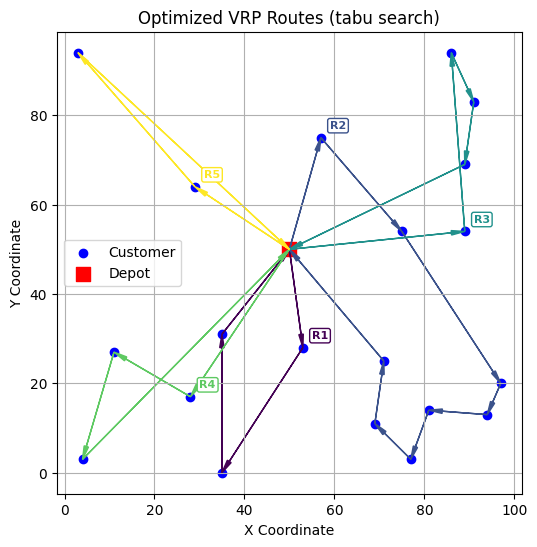

In [43]:
# --- Tabu Search Implementation ---
class TabuSearchVRP:
    def __init__(self, nodes_coords, distance_matrix, time_windows,
                 penalty_coeff, vehicle_speed,seed=43,
                 tabu_tenure_customer=5,
                 tabu_tenure_2opt=7,
                 max_iterations=750,
                 aspiration_offset=0.01):

        # 初始化随机数生成器
        self.rng = random.Random(seed)
        np.random.seed(seed)

        # 问题参数
        self.nodes_coords = nodes_coords
        self.dist_mat = distance_matrix
        self.time_windows = time_windows
        self.penalty_coeff = penalty_coeff
        self.speed = vehicle_speed

        # 算法参数
        self.tabu_tenure_customer = tabu_tenure_customer
        self.tabu_tenure_2opt = tabu_tenure_2opt
        self.max_iter = max_iterations
        self.aspiration = aspiration_offset

        # 状态变量
        self.best_solution = None
        self.best_cost = float('inf')
        self.current_solution = None
        self.current_cost = float('inf')
        self.tabu_list = []
        self.iteration = 0

    def _calculate_cost(self, solution):
        """复用已有的成本计算函数"""
        return calculate_solution_cost(
            solution,
            self.dist_mat,
            self.time_windows,
            self.penalty_coeff,
            self.speed
        )[0]

    def _generate_neighbors(self):
        """生成两种邻域解并验证有效性"""
        neighbors = []
        valid_customers = [c for route in self.current_solution
                          for c in route if c != 0]
        # 类型1: 客户迁移（保留路径有效性检查）
        random.seed(985)
        for _ in range(10):
            if not valid_customers:
                break
            cust = self.rng.choice(valid_customers)
            target_rid = self.rng.randint(0, len(self.current_solution)-1)
            target_route = self.current_solution[target_rid]
            insert_pos = random.randint(1, len(target_route)-1)

            # 生成新解
            new_sol = relocate_customer(
                deepcopy(self.current_solution),
                cust,
                target_rid,
                insert_pos
            )
            if new_sol and self._validate_solution(new_sol):
                neighbors.append(new_sol)

        # 类型2: 2-opt优化（增强索引检查）
        for route in self.current_solution:
            if len(route) >= 5:
                i = self.rng.randint(1, len(route)-3)
                j = self.rng.randint(i+1, len(route)-2)
                new_route = two_opt_swap(route, i, j)
                if new_route != route:
                 new_sol = [r if r != route else new_route
                           for r in self.current_solution]
                 if self._validate_solution(new_sol):
                    neighbors.append(new_sol)

        return neighbors

    def _validate_solution(self, solution):
        """验证解的完整性"""
        all_customers = set(range(1, len(self.nodes_coords)))
        covered = set()
        for route in solution:
            if len(route) < 2 or route[0] != 0 or route[-1] != 0:
                return False
            covered.update(route[1:-1])
        return covered == all_customers

    def _update_tabu(self, move_type, attributes):
        """禁忌表"""
        tenure = self.tabu_tenure_customer if move_type == 'relocate' \
                else self.tabu_tenure_2opt
        self.tabu_list.append({
            'type': move_type,
            'attr': attributes,
            'expire': self.iteration + tenure
        })

    def _is_tabu(self, move_type, attributes):
        """检查禁忌状态（带自动清理）"""
        # 移除过期条目
        self.tabu_list = [t for t in self.tabu_list
                         if t['expire'] > self.iteration]
        return any(t['type'] == move_type and t['attr'] == attributes
                  for t in self.tabu_list)

    def optimize(self):
        """执行禁忌搜索主循环"""
        # 初始化
        self.current_solution = initial_solution_greedy(
            self.dist_mat,
            self.time_windows,
            self.penalty_coeff,
            self.speed
        )
        self.current_cost = self._calculate_cost(self.current_solution)
        self.best_solution = deepcopy(self.current_solution)
        self.best_cost = self.current_cost

        # 优化循环
        for self.iteration in range(1, self.max_iter+1):
            neighbors = self._generate_neighbors()
            if not neighbors:
                continue

            # 寻找最佳候选解
            best_candidate = None
            best_cost = float('inf')
            best_move = (None, None)

            for candidate in neighbors:
                # 识别移动类型和属性（修复之前的索引错误）
                move_type, attributes = self._identify_move(candidate)
                if not move_type:
                    continue

                # 计算成本
                cost = self._calculate_cost(candidate)

                # 渴望准则检查
                is_aspiration = cost < (self.best_cost - self.aspiration)

                # 禁忌状态检查
                is_tabu = self._is_tabu(move_type, attributes)

                if (not is_tabu) or is_aspiration:
                    if cost < best_cost:
                        best_candidate = candidate
                        best_cost = cost
                        best_move = (move_type, attributes)

            # 更新当前解
            if best_candidate:
                self.current_solution = best_candidate
                self.current_cost = best_cost
                self._update_tabu(*best_move)

                # 更新全局最优
                if best_cost < self.best_cost:
                    self.best_solution = deepcopy(best_candidate)
                    self.best_cost = best_cost
                    print(f"Iter {self.iteration}: {self.best_cost:.2f}")

        return self.best_solution, self.best_cost

    def _identify_move(self, candidate):
        # 2-opt识别
        for rid in range(len(self.current_solution)):
            original_route = self.current_solution[rid]
            new_route = candidate[rid]
            if original_route != new_route:
                diff = [i for i, (o, n) in enumerate(zip(original_route, new_route))
                        if o != n]
                if len(diff) >= 2:
                    i = min(diff)
                    j = max(diff)
                    return '2opt', (rid, i, j)

        return None, None

# 使用
ts = TabuSearchVRP(
    nodes_coords=nodes_coords,
    distance_matrix=DISTANCE_MATRIX,
    time_windows=time_windows,
    penalty_coeff=PENALTY_LATE_COEFFICIENT,
    vehicle_speed=VEHICLE_SPEED,
    seed=5,
    tabu_tenure_customer=TS_TABU_TENURE_CUSTOMER,
    tabu_tenure_2opt=TS_TABU_TENURE_2OPT,
    max_iterations=TS_MAX_ITERATIONS,
    aspiration_offset=TS_ASPIRATION_OFFSET
)

best_solution, best_cost = ts.optimize()


# ================== 可视化优化解 ==================
def plot_optimized_solution(solution, total_cost):
    plt.figure(figsize=(6, 6))

    # 提取所有节点坐标
    x_coords, y_coords = zip(*nodes_coords)

    # 绘制基础元素
    plt.scatter(x_coords, y_coords, c='blue', label='Customer')
    plt.scatter(DEPOT_COORD[0], DEPOT_COORD[1],
                c='red', marker='s', s=100, label='Depot')

    # 生成颜色映射
    colors = plt.cm.viridis(np.linspace(0, 1, len(solution)))

    # 绘制每条路径
    for route_idx, route in enumerate(solution):
        path_points = [nodes_coords[node] for node in route]
        x = [p[0] for p in path_points]
        y = [p[1] for p in path_points]

        # 逐段绘制箭头
        for i in range(len(x)-1):
            plt.arrow(x[i], y[i],
                     (x[i+1]-x[i]), (y[i+1]-y[i]),
                     head_width=1,
                     head_length=3,
                     fc=colors[route_idx],
                     ec=colors[route_idx],
                     linewidth=1,
                     linestyle='-',
                     length_includes_head=True)

        if len(x) > 2:  # 确保有客户节点
            label_x = x[1] + 2  # X坐标偏移2个单位
            label_y = y[1] + 2  # Y坐标偏移2个单位
            plt.text(label_x, label_y,
                     f'R{route_idx+1}',  # 显示路径编号
                     color=colors[route_idx],
                     fontsize=8,
                     weight='bold',
                     bbox=dict(facecolor='white',
                                edgecolor=colors[route_idx],
                                boxstyle='round,pad=0.2'))
    # 标签设置
    plt.title(f'Optimized VRP Routes (tabu search)')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

# 执行可视化（使用禁忌搜索最优解）
plot_optimized_solution(best_solution, best_cost)